In [2]:
#from app.main.extraction.dxf_extraction_coordinator import DxfExtractionCoordinator
from app.main.models.wall import Wall
from app.main.models.point import Point

from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Point as shapePoint
import math
import numpy as np
import itertools as it
from scipy.spatial.distance import cdist
import ezdxf
import matplotlib.pyplot as plt

#file_path = "C:\\Users\\gianl\\Coding Workspace\\Python\\Nudata\\projektstudium-nudata-gruppe-b\\app\\main\\media\\Einfache_Plaene_Compass\\"
###########################################################################
file_path_simple = '../../media/Einfache_Plaene_Compass/'
file_path_architecture = '../../media/Architektenplaene/'
###########################################################################
file_name_simple = 'R-Bau_D_EG.dxf'
file_name_architecutre = 'R-Bau_A_EG.dxf'
file_name_architecutre1 = 'R-Bau_A_1OG.dxf'
file_name_architecutre2 = 'R-Bau_A_2OG.dxf'
###########################################################################
simple_dxf = ezdxf.readfile(file_path_simple+file_name_simple)
architecture_dxf = ezdxf.readfile(file_path_architecture+file_name_architecutre)
simple_model = simple_dxf.modelspace()
arichtecture_model = architecture_dxf.modelspace()

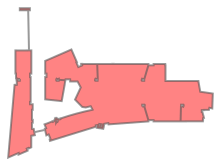

In [3]:
simple_polylines = simple_model.query("LWPolyline[layer=='BGF']").first.get_points('xy')
building_polygon = Polygon(simple_polylines)
building_polygon
#plt.plot(*building_polygon.exterior.xy)

In [4]:
simple_polylines2 = simple_model.query("LWPolyline[layer=='RAUMPOLYGON']")

NOTES FOR ARCHITECTURE PLAN:
- The LWPolylines of the Layer 'Leichtwand', 'Tragwand', 'Fassaden Elemente' and 'Stütze' are required
- In no layer is a constant pattern of the entities
- FAZIT: Every building is different
- The coordinates need the format xyseb

In the block below the task is to get all relevant informations from the architecture plan.

In [5]:

architecture_polylines = []
architecture_lines = []

#LWPolylines
leichtwand_polylines = arichtecture_model.query("LWPolyline[layer=='A_02_LEICHTWAND']")#.first.get_points('xy')
tragwand_polylines = arichtecture_model.query("LWPolyline[layer=='A_01_TRAGWAND']")#.first.get_points('xy')
fassaden_polylines = arichtecture_model.query("LWPolyline[layer=='A_05_FASSADE_ELEMENTE']")#.first.get_points('xy')
saeulen_polylines = arichtecture_model.query("LWPolyline[layer=='A_01_STUETZE']")#.first.get_points('xy')

#Lines
leichtwand_lines = arichtecture_model.query("LINE[layer=='A_02_LEICHTWAND']")
tragwand_lines = arichtecture_model.query("LINE[layer=='A_01_TRAGWAND']")
saeulen_lines = arichtecture_model.query("LINE[layer=='A_01_STUETZE']")
fassaden_lines = arichtecture_model.query("LINE[layer=='A_05_FASSADE_ELEMENTE']")

#Circles
pillars = arichtecture_model.query("CIRCLE[layer=='A_01_STUETZE']")

#Arcs
fassaden_arc = arichtecture_model.query("ARC[layer=='A_05_FASSADE_ELEMENTE']")

####################################
for x in leichtwand_polylines:
    architecture_polylines.append(x)

for x in tragwand_polylines:
    architecture_polylines.append(x)

for x in saeulen_polylines:
    architecture_polylines.append(x)

for x in fassaden_polylines:
    architecture_polylines.append(x)
####################################
for x in leichtwand_lines:
    architecture_lines.append(x)

for x in tragwand_lines:
    architecture_lines.append(x)
    
for x in saeulen_lines:
    architecture_lines.append(x)

for x in fassaden_lines:
    architecture_lines.append(x)
####################################



The next block shows us in a new dxf-File the extracted data.

In [6]:
doc = ezdxf.new('R2000')
msp = doc.modelspace()

#add Building Polygon in DXF File from simple Plan
#msp.add_lwpolyline(simple_polylines)

#add polylines to drawing
for x in architecture_polylines:
    msp.add_lwpolyline(x)

for x in simple_polylines2:
    msp.add_lwpolyline(x)


#add lines to drawing
coordinates = []
for e in architecture_lines:
    if e.dxftype() == 'LINE':
        tupel = (e.dxf.start, e.dxf.end)
        coordinates.append(tupel)

for x in coordinates:
    msp.add_line(x[0], x[1])


#add circle to drawing --> for matching of pillars
for x in pillars:
    msp.add_circle(x.dxf.center, x.dxf.radius, None)

#add arcs to drwawing
for x in fassaden_arc:
    msp.add_arc(x.dxf.center, x.dxf.radius, x.dxf.start_angle, x.dxf.end_angle, True, None)

doc.saveas("architectureplanextraction.dxf")

## Entity Overview of the relevant EZDXF Entities from the architectureplan for the matching.

In [7]:
#LWPolyline
print(architecture_polylines[0][0])
#Koordinatentupel im Format XYSEB

(-165.6145978773249, 7.983164791733174, 0.0, 0.0, 0.0)


In [8]:
#Lines
print(architecture_lines[0].dxf.start)#Startpunkt der Linie
print(architecture_lines[0].dxf.end)#Endpunkt der Linie
print(architecture_lines[0].dxf.thickness) #liniendicke default ist der Wert 0.
print(architecture_lines[0].dxf.extrusion)#?
#Koordinatentupel im Format XYSEB

(-154.82481884965, 25.03816414892228, 0.0)
(-155.16481884965, 25.03816414892228, 0.0)
0
(0.0, 0.0, 1.0)


In [9]:
#Arcs
print(fassaden_arc[0].dxf.center)
print(fassaden_arc[0].dxf.radius)
print(fassaden_arc[0].dxf.start_angle)
print(fassaden_arc[0].dxf.end_angle)
print(fassaden_arc[0].start_point)
print(fassaden_arc[0].end_point)

(-153.77481884965, 42.90816414892228, 0.0)
1.14
180.0
270.0
(-154.91481884964998, 42.90816414892228, 0.0)
(-153.77481884965, 41.76816414892228, 0.0)


In [10]:
#Circle
print(pillars[0].dxf.center)
print(pillars[0].dxf.radius)

(-113.9952156321787, 55.34433812884768, 0.0)
0.2
